In [1]:
# 视频动作分类

In [2]:
# 导入相关包

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

import IPython
from IPython.display import Image

2022-09-22 17:29:25.238664: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
# 序列长度（视频采样帧数）
MAX_SEQ_LENGTH = 20
# CNN提取特征向量大小
NUM_FEATURES = 1536
# 裁剪图片大小
IMG_SIZE = 299


In [5]:
# 读取文件名、标注
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")


In [6]:
# 查看数据集大小
len(train_df),len(test_df)

(5292, 2045)

In [7]:
train_df.sample(10)

,video_name,tag
1009,v_Billiards_g21_c07.avi,Billiards
3145,v_Nunchucks_g08_c02.avi,Nunchucks
1948,v_Drumming_g19_c04.avi,Drumming
5010,v_TennisSwing_g13_c04.avi,TennisSwing
4170,v_RockClimbingIndoor_g10_c07.avi,RockClimbingIndoor
2285,v_Haircut_g25_c02.avi,Haircut
3779,v_PlayingGuitar_g20_c06.avi,PlayingGuitar
1867,v_Diving_g24_c04.avi,Diving
3163,v_Nunchucks_g11_c02.avi,Nunchucks
3637,v_PlayingFlute_g16_c03.avi,PlayingFlute


In [8]:
# 中心裁剪

![](https://enpei-md.oss-cn-hangzhou.aliyuncs.com/img20220922173117.png?x-oss-process=style/wp)

In [9]:
# 裁剪正中间的正方形
def crop_center_square(img):
    # 获取长度和宽度
    h,w =  img.shape[:2]
    # 判断短边，作为正方形的边
    square_w = min(h,w)
    
    start_x = w//2 - square_w//2
    end_x = start_x + square_w
    
    start_y = h//2 - square_w//2
    end_y = start_y + square_w
    
    result = img[start_y:end_y,start_x:end_x]
    
    return result

In [10]:
# 测试图片
test_img = cv2.imread('./apple.jpg')

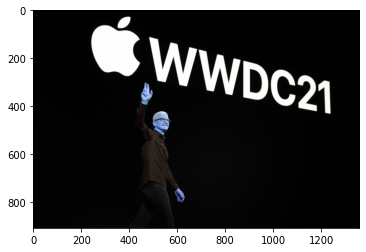

In [11]:
plt.imshow(test_img)

In [12]:
test_img_crop = crop_center_square(test_img)

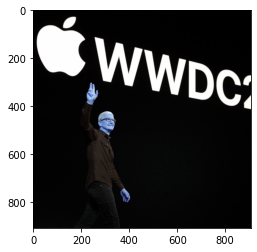

In [13]:
plt.imshow(test_img_crop)

In [14]:

# 加载视频
def load_video(filename):
    cap = cv2.VideoCapture(filename)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        # 中心裁剪
        frame = crop_center_square(frame)
        # 缩放
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        # BGR->RGB
        frame = frame[:, :, [2, 1, 0]]
        frames.append(frame)

    return np.array(frames)


In [15]:
# 测试一个文件
test_file = train_df['video_name'].values[200]
test_file

'v_Archery_g25_c03.avi'

In [16]:
frames = load_video(os.path.join('train', test_file))

In [17]:
frames.shape

(203, 299, 299, 3)

In [18]:
# 挑选前20帧显示
frames = frames[:20].astype(np.uint8)
# 保存为GIF
imageio.mimsave("animation.gif", frames, fps=10)

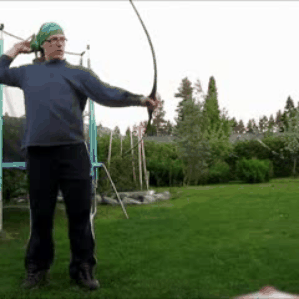

In [19]:
Image(filename='animation.gif',embed=True)

In [21]:

# 特征提取器
def build_feature_extractor():
    
    feature_extractor = keras.applications.inception_resnet_v2.InceptionResNetV2(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_resnet_v2.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


In [22]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 299, 299, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 299, 299, 3)       0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 1536)              54336736  
Total params: 54,336,736
Trainable params: 54,276,192
Non-trainable params: 60,544
_________________________________________________________________


In [23]:
import tqdm

In [25]:
# 将训练集处理成 (N, 20, 1536) (N, 1)
# 1.遍历视频文件
# 2.读取视频每一帧
# 3.统计帧数，如果不够需要补白，一共需要20帧
# 4.每一帧提取特征，特征长度1536，一个视频的特征(20,1536)
# 5.标签

In [26]:
# 所有标注
class_vocab = pd.unique(train_df["tag"]).tolist()

In [27]:
class_vocab

['ApplyEyeMakeup',
 'Archery',
 'BabyCrawling',
 'BandMarching',
 'BaseballPitch',
 'Basketball',
 'BasketballDunk',
 'BenchPress',
 'Biking',
 'Billiards',
 'Bowling',
 'BoxingPunchingBag',
 'BoxingSpeedBag',
 'BrushingTeeth',
 'CliffDiving',
 'CricketBowling',
 'CricketShot',
 'Diving',
 'Drumming',
 'FrontCrawl',
 'GolfSwing',
 'Haircut',
 'Hammering',
 'HammerThrow',
 'HandstandPushups',
 'HeadMassage',
 'HorseRiding',
 'IceDancing',
 'JumpRope',
 'Kayaking',
 'Nunchucks',
 'PlayingCello',
 'PlayingDaf',
 'PlayingDhol',
 'PlayingFlute',
 'PlayingGuitar',
 'PlayingSitar',
 'PoleVault',
 'Punch',
 'RockClimbingIndoor',
 'Rowing',
 'ShavingBeard',
 'Shotput',
 'Skiing',
 'SoccerJuggling',
 'SoccerPenalty',
 'TableTennisShot',
 'TennisSwing',
 'WallPushups',
 'WritingOnBoard']

In [28]:
# train_df["tag"].values.tolist()

In [29]:
# 处理所有视频
def load_dataset(dataset_df,dataset_dir):

    # 样本数量 N
    num_samples = len(dataset_df)
    # 文件路径
    video_paths = dataset_df["video_name"].values.tolist()
    # 动作标注
    labels = dataset_df["tag"].values

    labels_index  = [class_vocab.index(i) for i in labels]
    labels_index = np.array(labels_index).reshape(-1,1)


    # 整个数据集的特征，标注
    dataset_feats = []

    # 遍历视频文件
    for index,video in tqdm.tqdm(enumerate( video_paths )):
        # 读取视频每一帧
        frames = load_video(os.path.join(dataset_dir, video))
        frames_count = len(frames)

        # 如果视频帧数太短，则需要补白
        if frames_count < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - frames_count
            # 补全0图片数组
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))

            frames = np.concatenate((frames, padding))

        # 取前MAX_SEQ_LENGTH帧
        frames = frames[:MAX_SEQ_LENGTH,:]

        
        # 批量计算视频特征 N,1536
        video_feat = feature_extractor.predict(frames)
        

        # 追加进数据集特征
        dataset_feats.append(video_feat)

        # if index == 5:
        #     break

    dataset_feats = np.array(dataset_feats) 


    return dataset_feats,labels_index


In [30]:
# # 加载数据
# train_data, train_labels = load_dataset(train_df,'train')
# test_data, test_labels = load_dataset(test_df,'test')

In [31]:
# # 落盘
# np.save('./data_processed/train_data_incep.npy',train_data)
# np.save('./data_processed/train_labels_incep.npy',train_labels)

# np.save('./data_processed/test_data_incep.npy',test_data)
# np.save('./data_processed/test_labels_incep.npy',test_labels)

In [32]:
# 加载
train_data, train_labels = np.load('./data_processed/train_data_incep.npy'),np.load('./data_processed/train_labels_incep.npy')
test_data, test_labels = np.load('./data_processed/test_data_incep.npy'),np.load('./data_processed/test_labels_incep.npy')

In [33]:
train_data.shape,train_labels.shape,test_data.shape,test_labels.shape

((5292, 20, 1536), (5292, 1), (2045, 20, 1536), (2045, 1))

In [54]:
# 定义模型
def video_cls_model(class_vocab):
    # 类别数量
    classes_num = len(class_vocab)

    model = keras.Sequential([
        layers.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES)),
        # input: (N,20,1024), output: (N,32)
        layers.GRU(64, return_sequences=False),
        # output: (N,classes_num)
        layers.Dense(classes_num, activation="softmax")
    ])
    # 编译模型
    model.compile(
        optimizer=optimizers.Adam(0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [55]:
model = video_cls_model(class_vocab)

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 64)                307584    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                3250      
Total params: 310,834
Trainable params: 310,834
Non-trainable params: 0
_________________________________________________________________


In [57]:
# 训练
filepath = "./saved_model/rnn/video_classifier_rnn"
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1
)


In [58]:
history = model.fit(
        train_data,
        train_labels,
        validation_data=(test_data, test_labels),
        epochs=30,
        callbacks=[checkpoint],
    )

2022-09-22 17:36:30.696364: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 650280960 exceeds 10% of free system memory.


Epoch 1/30
166/166 [==============================] - 3s 10ms/step - loss: 3.4066 - accuracy: 0.2640 - val_loss: 2.8283 - val_accuracy: 0.5017

Epoch 00001: val_accuracy improved from -inf to 0.50171, saving model to ./saved_model/rnn/video_classifier_rnn
Epoch 2/30
166/166 [==============================] - 1s 7ms/step - loss: 2.3652 - accuracy: 0.6391 - val_loss: 2.1209 - val_accuracy: 0.6401

Epoch 00002: val_accuracy improved from 0.50171 to 0.64010, saving model to ./saved_model/rnn/video_classifier_rnn
Epoch 3/30
166/166 [==============================] - 1s 7ms/step - loss: 1.7911 - accuracy: 0.7343 - val_loss: 1.7211 - val_accuracy: 0.7144

Epoch 00003: val_accuracy improved from 0.64010 to 0.71443, saving model to ./saved_model/rnn/video_classifier_rnn
Epoch 4/30
166/166 [==============================] - 1s 7ms/step - loss: 1.4421 - accuracy: 0.7833 - val_loss: 1.4693 - val_accuracy: 0.7477

Epoch 00004: val_accuracy improved from 0.71443 to 0.74768, saving model to ./saved_m

In [59]:
# 测试训练好的模型
model.load_weights(filepath)
loss, accuracy = model.evaluate(test_data, test_labels)

64/64 [==============================] - 0s 4ms/step - loss: 0.6702 - accuracy: 0.8303


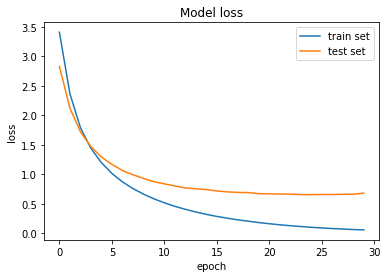

In [60]:
# 查看损失
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train set','test set'],loc='upper right')
plt.show()

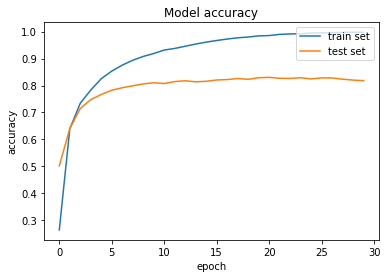

In [61]:
# 查看acc
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train set','test set'],loc='upper right')
plt.show()